# Blog Project

## Problem Definition

In this survey I analysed the StackOverflow Developer Survey from 2024. The goal is to create a regression machine learning model that predicts the target Job Satisfaction. Job Satisfaction is a value on a scale from 0 to 10.

I limited the features to 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'EdLevel', 'Country' and 'ConvertedCompYearly'.

## Import Libraries

In [858]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Model imports (e.g., logistic regression, random forest, etc.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Load Dataset

In [859]:
# Load data
df_raw = pd.read_csv('data/survey_results_public.csv')

In [860]:
# Define columns for futher investigation
cols_keep = ['MainBranch', 'Age', 'Employment', 'RemoteWork', 'EdLevel',
             'JobSat', 'Country', 'ConvertedCompYearly']

In [861]:
# Reduce dataset to the identified columns
df_red = df_raw[cols_keep]

## Basic Cleaning

In [862]:
# Remove all rows where the target "JobSat" is NaN
df_cleaned = df_red[df_red.JobSat.notna()]

In [863]:
# Check shape before and after removing JobSat NaN
print('Before: ', df_red.shape)
print('After: ', df_cleaned.shape)

Before:  (65437, 8)
After:  (29126, 8)


## Exploratory Data Analysis (EDA)

### Initial EDA

Here I take a first look at the data performing df.info() and df.describe(). Moreover, I begin simplifing the dataset by only including surveys where the respondand selected "Employed, full-time". This is by far the most selected value for Employment and simplifies the feature Employment a lot. Originally, it contained 64 unique values. At last, I remove three columns that contain no values for RemoteWork.

In [864]:
# Check data info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29126 entries, 10 to 65412
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MainBranch           29126 non-null  object 
 1   Age                  29126 non-null  object 
 2   Employment           29126 non-null  object 
 3   RemoteWork           29117 non-null  object 
 4   EdLevel              29126 non-null  object 
 5   JobSat               29126 non-null  float64
 6   Country              29126 non-null  object 
 7   ConvertedCompYearly  16075 non-null  float64
dtypes: float64(2), object(6)
memory usage: 2.0+ MB


In [865]:
# Describe features and target
df_cleaned.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,EdLevel,JobSat,Country,ConvertedCompYearly
count,29126,29126,29126,29117,29126,29126.000000,29126,1.607500e+04
unique,5,8,64,3,8,NaN,166,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,United States of America,NaN
freq,26627,12700,22537,12622,13126,NaN,5534,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.935041,NaN,8.594299e+04
std,NaN,NaN,NaN,NaN,NaN,2.088259,NaN,1.722364e+05
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,3.356900e+04
50%,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,6.590700e+04
75%,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,1.082800e+05


In [866]:
# Check for missing values
print(df_cleaned.isnull().sum().sort_values(ascending=False))
print(df_cleaned.isnull().mean().sort_values(ascending=False))

ConvertedCompYearly    13051
RemoteWork                 9
MainBranch                 0
Age                        0
Employment                 0
EdLevel                    0
JobSat                     0
Country                    0
dtype: int64
ConvertedCompYearly    0.448088
RemoteWork             0.000309
MainBranch             0.000000
Age                    0.000000
Employment             0.000000
EdLevel                0.000000
JobSat                 0.000000
Country                0.000000
dtype: float64


In [867]:
# Reduce dataset to 'employed, full-time' and then drop column 'Employment'
df_cleaned = df_cleaned[df_cleaned.Employment == 'Employed, full-time']
df_cleaned.drop(columns='Employment', inplace=True)

In [868]:
# Repeat description of categorical features and numerical target variable
df_cleaned.describe(include='all')

,MainBranch,Age,RemoteWork,EdLevel,JobSat,Country,ConvertedCompYearly
count,22537,22537,22534,22537,22537.000000,22537,1.254400e+04
unique,5,8,3,8,NaN,158,NaN
top,I am a developer by profession,25-34 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,United States of America,NaN
freq,20668,10258,10006,10497,NaN,4732,NaN
mean,NaN,NaN,NaN,NaN,6.919288,NaN,8.942110e+04
std,NaN,NaN,NaN,NaN,2.072053,NaN,1.435716e+05
min,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,6.000000,NaN,3.866600e+04
50%,NaN,NaN,NaN,NaN,7.000000,NaN,7.000000e+04
75%,NaN,NaN,NaN,NaN,8.000000,NaN,1.120000e+05


In [869]:
# Drop rows where RemoteWork is na
df_cleaned = df_cleaned.dropna(subset='RemoteWork')

### Univariate Analysis

In the univariate analysis I looked at each feature at a time conducting methos like count absolute and relative frequency of the categorical values. Furthermore, I simplified the categorical features aggregating values that made up less than 1% of all values to the category "Others". Lastly, I created bar plots showing the distribution of each feature and the target.

#### Absolute and relative frequency

In [870]:
# Count frequency and relative frequency values of MainBranch
print(df_cleaned.MainBranch.value_counts(), '\n')
print(df_cleaned.MainBranch.value_counts(normalize=True))

MainBranch
I am a developer by profession                                                           20665
I am not primarily a developer, but I write code sometimes as part of my work/studies     1322
I used to be a developer by profession, but no longer am                                   353
I am learning to code                                                                      103
I code primarily as a hobby                                                                 91
Name: count, dtype: int64 

MainBranch
I am a developer by profession                                                           0.917059
I am not primarily a developer, but I write code sometimes as part of my work/studies    0.058667
I used to be a developer by profession, but no longer am                                 0.015665
I am learning to code                                                                    0.004571
I code primarily as a hobby                                                        

In [871]:
# Count frequency and relative frequency values of Age
print(df_cleaned.Age.value_counts(), '\n')
print(df_cleaned.Age.value_counts(normalize=True))

Age
25-34 years old       10258
35-44 years old        6392
18-24 years old        2580
45-54 years old        2371
55-64 years old         795
65 years or older        86
Prefer not to say        35
Under 18 years old       17
Name: count, dtype: int64 

Age
25-34 years old       0.455223
35-44 years old       0.283660
18-24 years old       0.114494
45-54 years old       0.105219
55-64 years old       0.035280
65 years or older     0.003816
Prefer not to say     0.001553
Under 18 years old    0.000754
Name: proportion, dtype: float64


In [872]:
# Count frequency and relative frequency values of RemoteWork
print(df_cleaned.RemoteWork.value_counts(), '\n')
print(df_cleaned.RemoteWork.value_counts(normalize=True))

RemoteWork
Hybrid (some remote, some in-person)    10006
Remote                                   8038
In-person                                4490
Name: count, dtype: int64 

RemoteWork
Hybrid (some remote, some in-person)    0.444040
Remote                                  0.356705
In-person                               0.199254
Name: proportion, dtype: float64


In [873]:
# Count frequency and relative frequency values of EdLevel
print(df_cleaned.EdLevel.value_counts(), '\n')
print(df_cleaned.EdLevel.value_counts(normalize=True))

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          10496
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        6729
Some college/university study without earning a degree                                 2285
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         1147
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)      891
Associate degree (A.A., A.S., etc.)                                                     674
Something else                                                                          214
Primary/elementary school                                                                98
Name: count, dtype: int64 

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          0.465785
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       0.298615
Some college/university study 

In [874]:
# Count frequency and relative frequency values of Country
print(df_cleaned.Country.value_counts(), '\n')
print(df_cleaned.Country.value_counts(normalize=True))

Country
United States of America                                4732
Germany                                                 1935
India                                                   1707
United Kingdom of Great Britain and Northern Ireland    1393
Ukraine                                                  862
                                                        ... 
Somalia                                                    1
Belize                                                     1
Togo                                                       1
Liechtenstein                                              1
Suriname                                                   1
Name: count, Length: 158, dtype: int64 

Country
United States of America                                0.209994
Germany                                                 0.085870
India                                                   0.075752
United Kingdom of Great Britain and Northern Ireland    0.061818
Ukraine     

In [875]:
# Count values for the target JobSat
df_cleaned.JobSat.value_counts().sort_index()

JobSat
0.0      242
1.0      209
2.0      599
3.0      900
4.0      848
5.0     1533
6.0     2924
7.0     5032
8.0     5832
9.0     2824
10.0    1591
Name: count, dtype: int64

#### Simplification of categorical features

In [876]:
# Create a copy dataframe for categorical data simplification steps
df_simplified = df_cleaned.copy()

In [877]:
# Group rare values that make up less than 1% of the MainBranch data

# Identify how often each value in column "MainBranch" occurs
count = df_cleaned.MainBranch.value_counts(normalize=True)

# Identify values that make up less than 1%
under_one_percent = count[count < 0.01].index

# Reassining the identified rare values to "Other" and create new simplified column
df_simplified["MainBranch_simplified"] = np.where(df_simplified.MainBranch.isin(under_one_percent), "Other", df_cleaned.MainBranch)

# Remove original column
df_simplified.drop(columns=["MainBranch"], inplace=True)

In [878]:
# Group rare values that make up less than 1% of the Age data

# Identify how often each value in column "Age" occurs
count = df_cleaned.Age.value_counts(normalize=True)

# Identify values that make up less than 1%
under_one_percent = count[count < 0.01].index

# Reassining the identified rare values to "Other" and create new simplified column
df_simplified["Age_simplified"] = np.where(df_simplified.Age.isin(under_one_percent), "Other", df_cleaned.Age)

# Remove original column
df_simplified.drop(columns=["Age"], inplace=True)

In [879]:
# Group rare values that make up less than 1% of the EdLevel data

# Identify how often each value in column "EdLevel" occurs
count = df_cleaned.EdLevel.value_counts(normalize=True)

# Identify values that make up less than 1%
under_one_percent = count[count < 0.01].index

# Reassining the identified rare values to "Other" and create new simplified column
df_simplified["EdLevel_simplified"] = np.where(df_simplified.EdLevel.isin(under_one_percent), "Other", df_cleaned.EdLevel)

# Remove original column
df_simplified.drop(columns=["EdLevel"], inplace=True)

In [880]:
# Group rare values that make up less than 1% of the Country data

# Identify how often each value in column "Country" occurs
count = df_cleaned.Country.value_counts(normalize=True)

# Identify values that make up less than 1%
under_one_percent = count[count < 0.01].index

# Reassining the identified rare values to "Other" and create new simplified column
df_simplified["Country_simplified"] = np.where(df_simplified.Country.isin(under_one_percent), "Other", df_cleaned.Country)

# Remove original column
df_simplified.drop(columns=["Country"], inplace=True)

#### Description of simplified data

In [881]:
# Repeat description but this time with the simplified columns
df_simplified.describe(include='object')

,RemoteWork,MainBranch_simplified,Age_simplified,EdLevel_simplified,Country_simplified
count,22534,22534,22534,22534,22534
unique,3,4,6,7,19
top,"Hybrid (some remote, some in-person)",I am a developer by profession,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Other
freq,10006,20665,10258,10496,5623


In [882]:
df_simplified.describe()

,JobSat,ConvertedCompYearly
count,22534.000000,1.254300e+04
mean,6.919056,8.941364e+04
std,2.072065,1.435749e+05
min,0.000000,1.000000e+00
25%,6.000000,3.866600e+04
50%,7.000000,7.000000e+04
75%,8.000000,1.120000e+05
max,10.000000,9.000000e+06


#### Bar Plots of each feature and the target

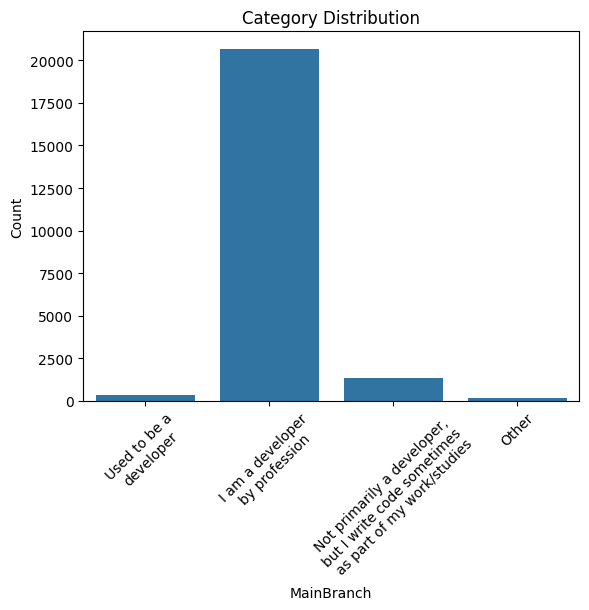

In [883]:
# Bar Plot of MainBranch
# Replace long labels with line-broken versions just for plotting
label_map = {
    "I am a developer by profession": "I am a developer\nby profession",
    "I used to be a developer by profession, but no longer am": "Used to be a\ndeveloper",
    "I am not primarily a developer, but I write code sometimes as part of my work/studies": "Not primarily a developer,\nbut I write code sometimes \nas part of my work/studies",
    "Other": "Other"
}

# Copy DataFrame to avoid modifying original
df_plot = df_simplified.copy()
df_plot['MainBranch_simplified_wrapped'] = df_plot['MainBranch_simplified'].replace(label_map)

# Plot
sns.countplot(x='MainBranch_simplified_wrapped', data=df_plot)
plt.title("Category Distribution")
plt.xlabel("MainBranch")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

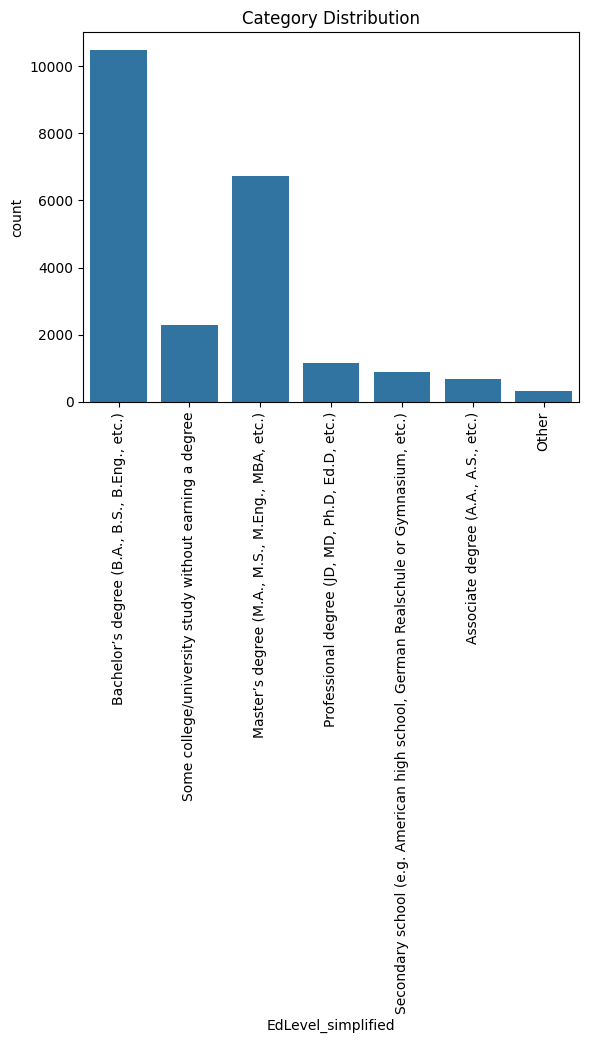

In [884]:
# Bar Plot of EdLevel
sns.countplot(x='EdLevel_simplified', data=df_simplified)
plt.xticks(rotation=90)
plt.title("Category Distribution")
plt.show()

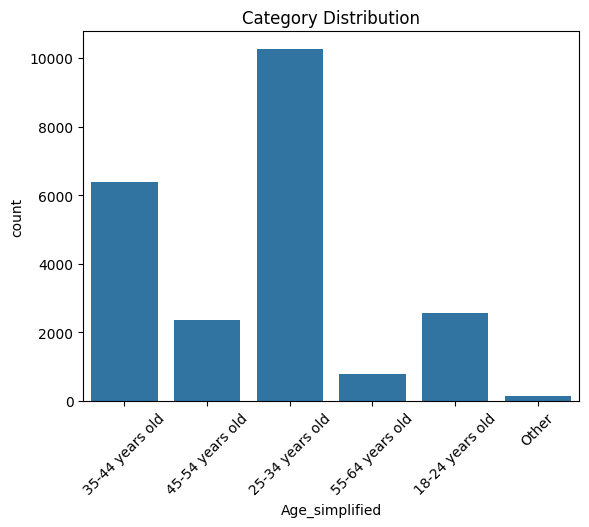

In [885]:
# Bar Plot of Age
sns.countplot(x='Age_simplified', data=df_simplified)
plt.xticks(rotation=45)
plt.title("Category Distribution")
plt.show()

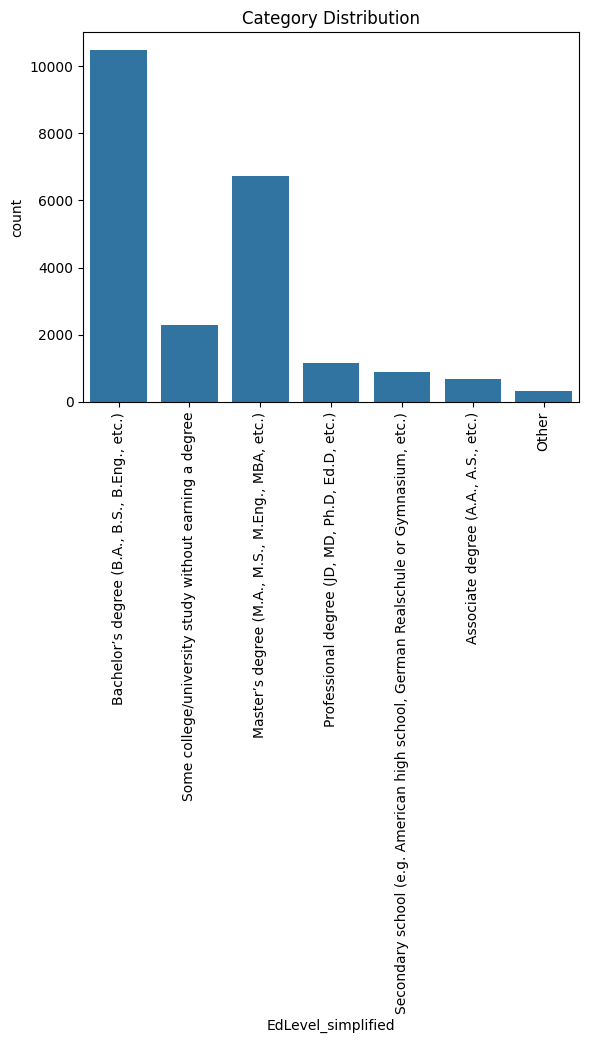

In [886]:
# Bar Plot of EdLevel
sns.countplot(x='EdLevel_simplified', data=df_simplified)
plt.xticks(rotation=90)
plt.title("Category Distribution")
plt.show()

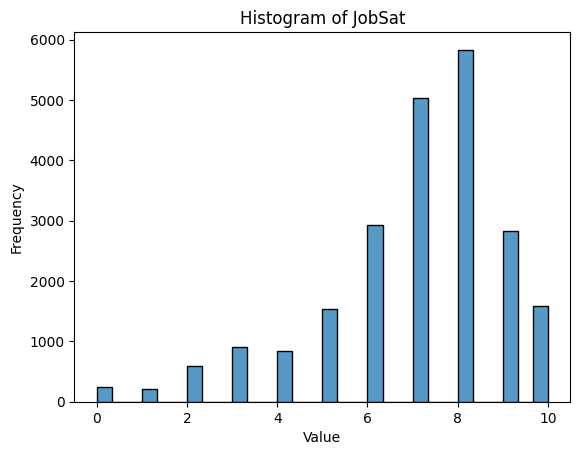

In [887]:
# Bar Plot of JobSat
sns.histplot(data=df_simplified, x='JobSat', bins=30, kde=False)
plt.title('Histogram of JobSat')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

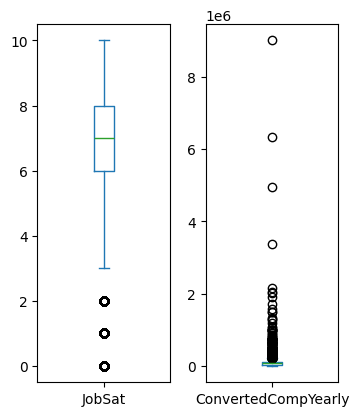

In [888]:
# Box plots for numerical data
df_simplified.plot(kind="box", subplots=True, layout=(2, 7), figsize=(12, 8), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [889]:
# Identify outliers with the method interquartile range (IQR)
lower_bound = df_simplified.ConvertedCompYearly.quantile(0.01)
upper_bound = df_simplified.ConvertedCompYearly.quantile(0.99)
outliers = df_simplified[(df_simplified.ConvertedCompYearly < lower_bound) | (df_simplified.ConvertedCompYearly > upper_bound)]


In [890]:
# Remove outliers in the column ConvertedCompYearly
df_simplified = df_simplified.drop(outliers.index)

/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/1048088565.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


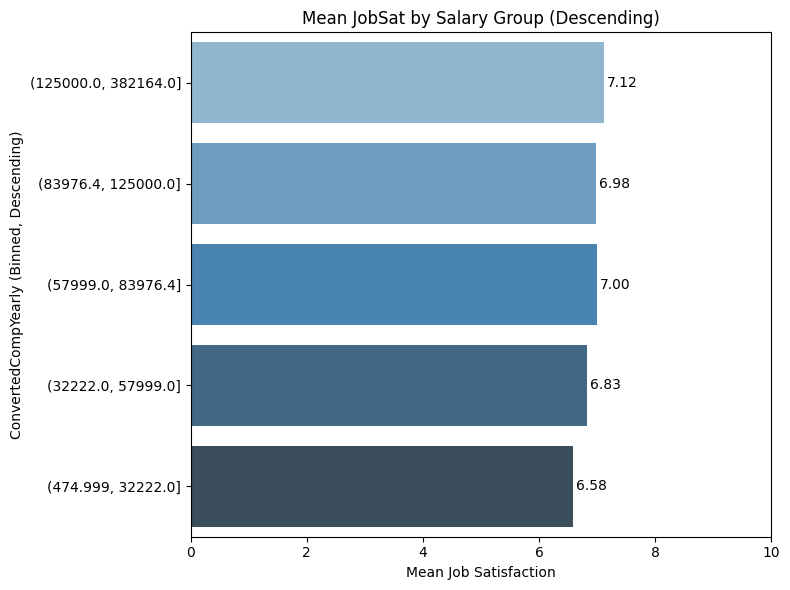

In [891]:
# Histogram of ConvertedCompYearly
# Bin salary column
df_simplified["SalaryBin"] = pd.qcut(df_simplified["ConvertedCompYearly"], q=5, duplicates='drop')

# Group and calculate mean JobSat
salary_stats = df_simplified.groupby("SalaryBin", observed=True)["JobSat"].agg(mean_JobSat="mean", count="count").reset_index()

# Sort bins by lower bound descending
salary_stats["bin_start"] = salary_stats["SalaryBin"].apply(lambda x: x.left)
salary_stats = salary_stats.sort_values("bin_start", ascending=False)

# Convert bins to string and use as ordered category
salary_stats["SalaryBinStr"] = salary_stats["SalaryBin"].astype(str)
salary_stats["SalaryBinStr"] = pd.Categorical(
    salary_stats["SalaryBinStr"],
    categories=salary_stats["SalaryBinStr"],
    ordered=True
)

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=salary_stats,
    y="SalaryBinStr",
    x="mean_JobSat",
    palette="Blues_d"
)

# Add text labels
for i, val in enumerate(salary_stats["mean_JobSat"]):
    ax.text(val + 0.05, i, f"{val:.2f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("ConvertedCompYearly (Binned, Descending)")
plt.xlim(0, 10)
plt.title("Mean JobSat by Salary Group (Descending)")
plt.tight_layout()
plt.show()

In [892]:
# Drop columns "SalaryBin" as it is no longer needed
df_simplified.drop(columns='SalaryBin', inplace=True)

### Bivariate Analysis

Following I evaluated the features in combination with the target JobSat. I calculated the average JobSat for each value of each feature. Additionally, I visualised the results in bar charts. Lastly, I conducted Tukey HSD test to test the feature's significance.

#### Mean target value and count for each value of each feature

In [893]:
# Mean target values for values in MainBranch 
df_simplified.groupby(['MainBranch_simplified']).agg(mean_JobSat=('JobSat', 'mean'), count=('MainBranch_simplified', 'count')).sort_values('mean_JobSat', ascending=False)


,mean_JobSat,count
MainBranch_simplified,,
I am a developer by profession,6.950250,20422
"I used to be a developer by profession, but no longer am",6.903683,353
"I am not primarily a developer, but I write code sometimes as part of my work/studies",6.640791,1314
Other,5.613402,194


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/3189391106.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


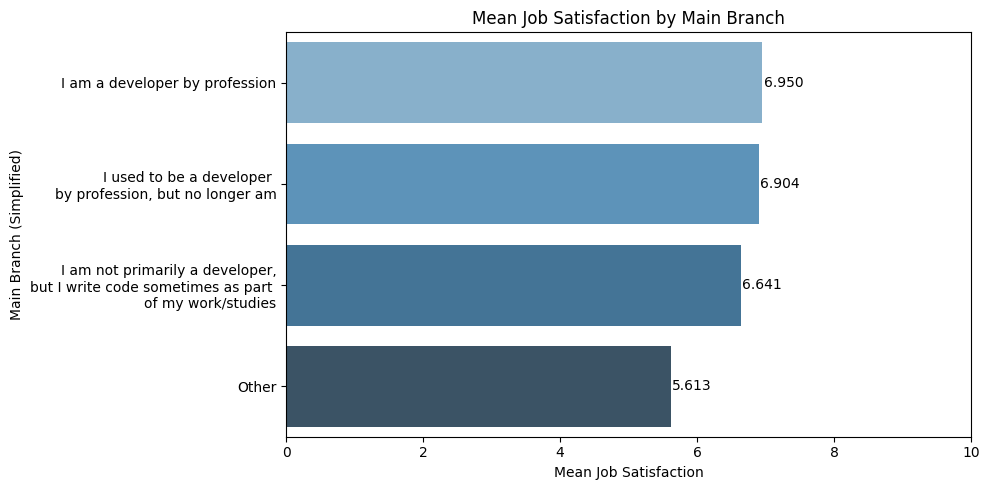

In [894]:
# Bar Chart MainBranch and average JobSat
# Data
data = {
    'MainBranch_simplified': [
        "I am a developer by profession",
        "I used to be a developer \nby profession, but no longer am",
        "I am not primarily a developer,\nbut I write code sometimes as part \nof my work/studies",
        "Other"
    ],
    'mean_JobSat': [6.950250, 6.903683, 6.640791, 5.613402]
}

df_plot = pd.DataFrame(data)

# Sort by mean_JobSat descending
df_plot = df_plot.sort_values("mean_JobSat", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_plot,
    x="mean_JobSat",
    y="MainBranch_simplified",
    palette="Blues_d"
)

for i in range(len(df_plot)):
    value = df_plot["mean_JobSat"].iloc[i]
    ax.text(value + 0.02, i, f"{value:.3f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("Main Branch (Simplified)")
plt.title("Mean Job Satisfaction by Main Branch")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

In [895]:
# Mean target values for values in Age 
df_simplified.groupby(['Age_simplified']).agg(mean_JobSat=('JobSat', 'mean'), count=('Age_simplified', 'count')).sort_values('mean_JobSat', ascending=False)


,mean_JobSat,count
Age_simplified,,
Other,7.591241,137
55-64 years old,7.219543,788
45-54 years old,7.106293,2352
35-44 years old,6.979408,6313
25-34 years old,6.873534,10145
18-24 years old,6.653846,2548


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/4225390698.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


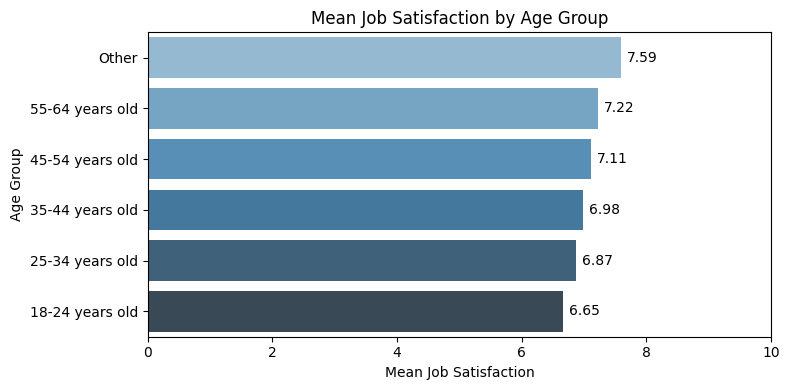

In [896]:
# Bar Chart Age and average JobSat
# Data
data = {
    'Age_simplified': [
        "Other",
        "55-64 years old",
        "45-54 years old",
        "35-44 years old",
        "25-34 years old",
        "18-24 years old"
    ],
    'mean_JobSat': [7.591241, 7.219543, 7.106293, 6.979408, 6.873534, 6.653846]
}

df_plot = pd.DataFrame(data)

# Sort descending by mean_JobSat
df_plot = df_plot.sort_values("mean_JobSat", ascending=False)

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=df_plot,
    x="mean_JobSat",
    y="Age_simplified",
    palette="Blues_d"
)

for i in range(len(df_plot)):
    value = df_plot["mean_JobSat"].iloc[i]
    ax.text(value + 0.1, i, f"{value:.2f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("Age Group")
plt.title("Mean Job Satisfaction by Age Group")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

In [897]:
# Mean target values for values in RemoteWork 
df_simplified.groupby(['RemoteWork']).agg(mean_JobSat=('JobSat', 'mean'), count=('RemoteWork', 'count')).sort_values('mean_JobSat', ascending=False)


,mean_JobSat,count
RemoteWork,,
Remote,7.045954,7921
"Hybrid (some remote, some in-person)",6.947395,9942
In-person,6.630769,4420


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/2441204722.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


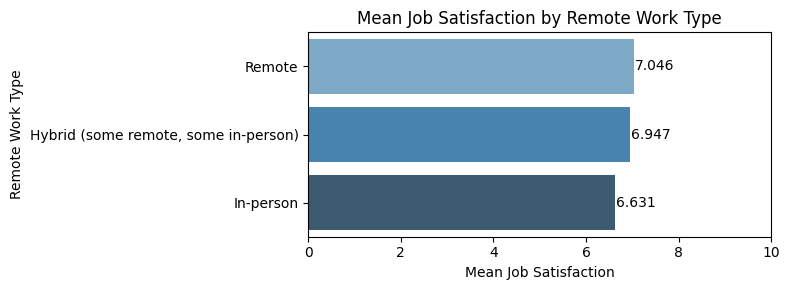

In [898]:
# Bar Chart RemoteWork and average JobSat
# Data
data = {
    'RemoteWork': [
        "Remote",
        "Hybrid (some remote, some in-person)",
        "In-person"
    ],
    'mean_JobSat': [7.045954, 6.947395, 6.630769]
}

df_plot = pd.DataFrame(data)

# Sort descending by mean_JobSat
df_plot = df_plot.sort_values("mean_JobSat", ascending=False)

plt.figure(figsize=(8, 3))
ax = sns.barplot(
    data=df_plot,
    x="mean_JobSat",
    y="RemoteWork",
    palette="Blues_d"
)

for i in range(len(df_plot)):
    value = df_plot["mean_JobSat"].iloc[i]
    ax.text(value + 0.02, i, f"{value:.3f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("Remote Work Type")
plt.title("Mean Job Satisfaction by Remote Work Type")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

In [899]:
# Mean target values for values in EdLevel
df_simplified.groupby(['EdLevel_simplified']).agg(mean_JobSat=('JobSat', 'mean'), count=('EdLevel_simplified', 'count')).sort_values('mean_JobSat', ascending=False)


,mean_JobSat,count
EdLevel_simplified,,
"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",7.059187,1132
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6.980749,6649
"Associate degree (A.A., A.S., etc.)",6.920540,667
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.893277,10382
Some college/university study without earning a degree,6.853853,2258
Other,6.852941,306
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",6.781777,889


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/3769790781.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


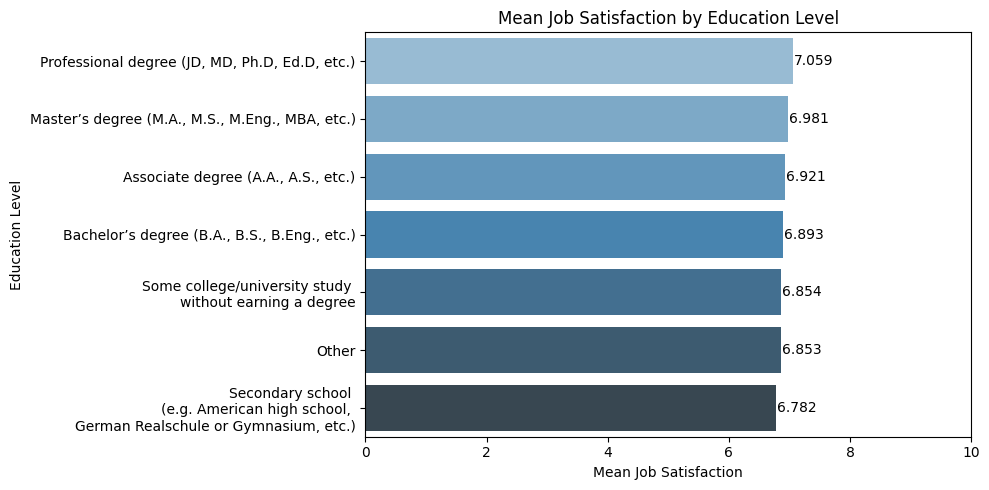

In [900]:
# Bar Chart EdLevel and average JobSat
# Data
data = {
    'EdLevel_simplified': [
        "Professional degree (JD, MD, Ph.D, Ed.D, etc.)",
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",
        "Associate degree (A.A., A.S., etc.)",
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)",
        "Some college/university study \nwithout earning a degree",
        "Other",
        "Secondary school \n(e.g. American high school, \nGerman Realschule or Gymnasium, etc.)"
    ],
    'mean_JobSat': [7.059187, 6.980749, 6.920540, 6.893277, 6.853853, 6.852941, 6.781777]
}

df_plot = pd.DataFrame(data)

# Sort descending by mean_JobSat
df_plot = df_plot.sort_values("mean_JobSat", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_plot,
    x="mean_JobSat",
    y="EdLevel_simplified",
    palette="Blues_d"
)

for i in range(len(df_plot)):
    value = df_plot["mean_JobSat"].iloc[i]
    ax.text(value + 0.02, i, f"{value:.3f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("Education Level")
plt.title("Mean Job Satisfaction by Education Level")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

In [901]:
# Mean target values for values in Country
df_simplified.groupby(['Country_simplified']).agg(mean_JobSat=('JobSat', 'mean'), count=('Country_simplified', 'count')).sort_values('mean_JobSat', ascending=False)


,mean_JobSat,count
Country_simplified,,
Israel,7.400000,245
Ukraine,7.265380,829
Austria,7.243542,271
Canada,7.172808,787
Netherlands,7.142857,525
Sweden,7.140312,449
Brazil,7.118397,549
Switzerland,7.032258,341
France,7.016477,789


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/250834827.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


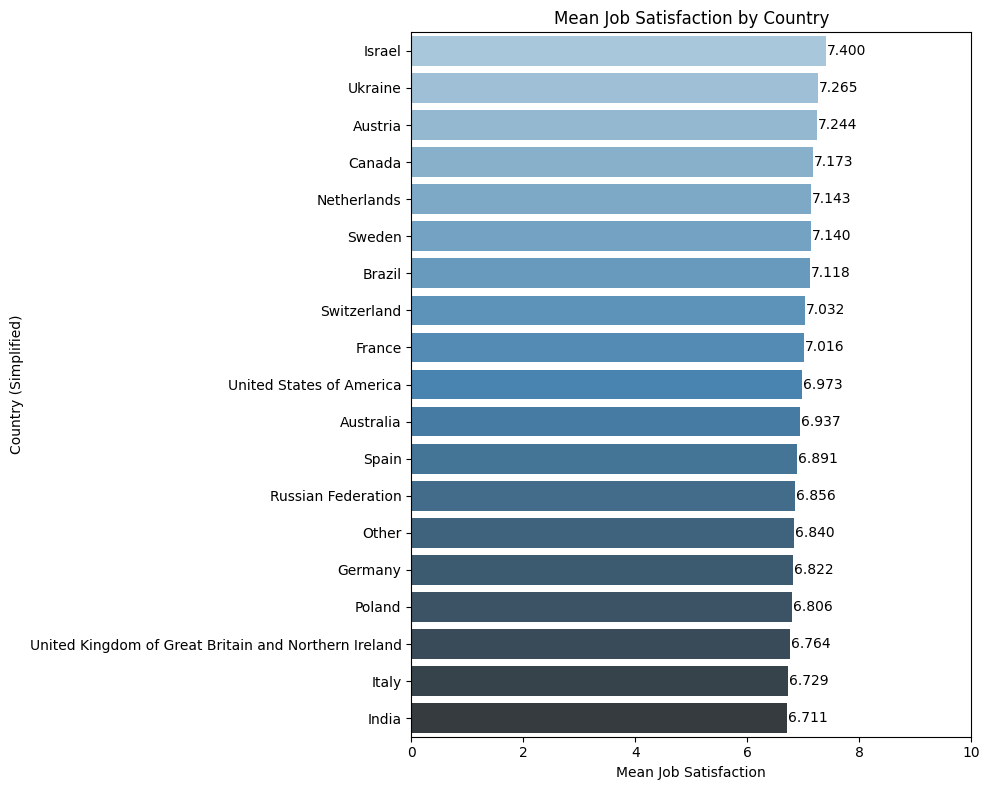

In [902]:
# Bar Chart Country and average JobSat
# Data
data = {
    'Country_simplified': [
        "Israel", "Ukraine", "Austria", "Canada", "Netherlands", "Sweden", "Brazil",
        "Switzerland", "France", "United States of America", "Australia", "Spain",
        "Russian Federation", "Other", "Germany", "Poland",
        "United Kingdom of Great Britain and Northern Ireland", "Italy", "India"
    ],
    'mean_JobSat': [
        7.400000, 7.265380, 7.243542, 7.172808, 7.142857, 7.140312, 7.118397,
        7.032258, 7.016477, 6.973463, 6.937238, 6.891304,
        6.856209, 6.840360, 6.821946, 6.806452,
        6.763518, 6.728782, 6.710666
    ]
}

df_plot = pd.DataFrame(data)

# Sort by mean_JobSat descending
df_plot = df_plot.sort_values("mean_JobSat", ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=df_plot,
    x="mean_JobSat",
    y="Country_simplified",
    palette="Blues_d"
)

# Add value labels
for i in range(len(df_plot)):
    value = df_plot["mean_JobSat"].iloc[i]
    ax.text(value + 0.02, i, f"{value:.3f}", va="center")

plt.xlabel("Mean Job Satisfaction")
plt.ylabel("Country (Simplified)")
plt.title("Mean Job Satisfaction by Country")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

#### Tukey HSD tests

In [903]:
# Run Tukey HSD test to check significance for MainBranch
tukey = pairwise_tukeyhsd(
    endog=df_simplified['JobSat'],
    groups=df_simplified['MainBranch_simplified'],
    alpha=0.05
)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
I am a developer by profession,"I am not primarily a developer, but I write code sometimes as part of my work/studies",-0.3095,0.0,-0.4605,-0.1584,True
I am a developer by profession,"I used to be a developer by profession, but no longer am",-0.0466,0.9751,-0.3315,0.2383,False
I am a developer by profession,Other,-1.3368,0.0,-1.7197,-0.954,True
"I am not primarily a developer, but I write code sometimes as part of my work/studies","I used to be a developer by profession, but no longer am",0.2629,0.1458,-0.0553,0.5811,False
"I am not primarily a developer, but I write code sometimes as part of my work/studies",Other,-1.0274,0.0,-1.4356,-0.6192,True
"I used to be a developer by profession, but no longer am",Other,-1.2903,0.0,-1.7646,-0.816,True


In [904]:
# Run Tukey HSD test to check significance for Age
tukey = pairwise_tukeyhsd(
    endog=df_simplified['JobSat'],
    groups=df_simplified['Age_simplified'],
    alpha=0.05
)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
18-24 years old,25-34 years old,0.2197,0.0,0.0892,0.3502,True
18-24 years old,35-44 years old,0.3256,0.0,0.1874,0.4638,True
18-24 years old,45-54 years old,0.4524,0.0,0.2841,0.6208,True
18-24 years old,55-64 years old,0.5657,0.0,0.3257,0.8057,True
18-24 years old,Other,0.9374,0.0,0.421,1.4538,True
25-34 years old,35-44 years old,0.1059,0.0175,0.0115,0.2003,True
25-34 years old,45-54 years old,0.2328,0.0,0.098,0.3675,True
25-34 years old,55-64 years old,0.346,0.0001,0.1283,0.5637,True
25-34 years old,Other,0.7177,0.0008,0.2113,1.2241,True
35-44 years old,45-54 years old,0.1269,0.112,-0.0153,0.2691,False


In [905]:
# Run Tukey HSD test to check significance for RemoteWork
tukey = pairwise_tukeyhsd(
    endog=df_simplified['JobSat'],
    groups=df_simplified['RemoteWork'],
    alpha=0.05
)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
"Hybrid (some remote, some in-person)",In-person,-0.3166,0.0,-0.4041,-0.2291,True
"Hybrid (some remote, some in-person)",Remote,0.0986,0.0044,0.0257,0.1715,True
In-person,Remote,0.4152,0.0,0.3243,0.5061,True


In [906]:
# Run Tukey HSD test to check significance for EdLevel
tukey = pairwise_tukeyhsd(
    endog=df_simplified['JobSat'],
    groups=df_simplified['EdLevel_simplified'],
    alpha=0.05
)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
"Associate degree (A.A., A.S., etc.)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",-0.0273,0.9999,-0.271,0.2165,False
"Associate degree (A.A., A.S., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.0602,0.9917,-0.1877,0.3081,False
"Associate degree (A.A., A.S., etc.)",Other,-0.0676,0.9992,-0.489,0.3538,False
"Associate degree (A.A., A.S., etc.)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",0.1386,0.8167,-0.1593,0.4366,False
"Associate degree (A.A., A.S., etc.)","Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",-0.1388,0.8482,-0.4514,0.1739,False
"Associate degree (A.A., A.S., etc.)",Some college/university study without earning a degree,-0.0667,0.9907,-0.3356,0.2023,False
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.0875,0.1006,-0.0084,0.1833,False
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Other,-0.0403,0.9999,-0.3943,0.3137,False
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",0.1659,0.1382,-0.0251,0.3569,False
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",-0.1115,0.7196,-0.3248,0.1018,False


In [907]:
# Run Tukey HSD test to check significance for Country
tukey = pairwise_tukeyhsd(
    endog=df_simplified['JobSat'],
    groups=df_simplified['Country_simplified'],
    alpha=0.05
)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Australia,Austria,0.3063,0.9083,-0.2462,0.8588,False
Australia,Brazil,0.1812,0.997,-0.2734,0.6357,False
Australia,Canada,0.2356,0.9017,-0.1858,0.6569,False
Australia,France,0.0792,1.0,-0.3419,0.5004,False
Australia,Germany,-0.1153,0.9999,-0.4865,0.2559,False
Australia,India,-0.2266,0.8281,-0.6028,0.1497,False
Australia,Israel,0.4628,0.301,-0.1081,1.0337,False
Australia,Italy,-0.2085,0.9854,-0.6644,0.2475,False
Australia,Netherlands,0.2056,0.9884,-0.2537,0.665,False
Australia,Other,-0.0969,1.0,-0.4432,0.2495,False


## Feature Engineering (before train-test-split)

### Overview of the encoding strategies

- RemoteWork and MainBranch_simplified: **One-Hot Encoding**, AFTER train-test-split
- Age_simplified and EdLevel_simplified: **Ordinal Encoding**, BEFORE train-test-split 
- Country_simplified: **Target Encoding**, AFTER train-test-split
- ConvertedCompYearly: **Imutation**, AFTER traint-test-split

#### Ordinal Encoding

In [908]:
# Copy df_simplified
df_encoded = df_simplified.copy()

In [909]:
# Encode Age_simplified
Age_order = {
    '18-24 years old': 0,
    '25-34 years old': 1,
    '35-44 years old': 2,
    '45-54 years old': 3,
    '55-64 years old': 4,
    'Other': 5
}

df_encoded['Age_simplified'] = df_simplified['Age_simplified'].map(Age_order)

In [910]:
# Encode EdLevel_simplified
EdLevel_order = {
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 0,
    'Some college/university study without earning a degree': 1,
    'Associate degree (A.A., A.S., etc.)': 2,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 3,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 4,
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 5,
    'Other': 6
}

df_encoded['EdLevel_simplified'] = df_simplified['EdLevel_simplified'].map(EdLevel_order)

## Train-Test-Split

In [911]:
# Create train and test datasets
y = df_encoded.JobSat
X = df_encoded.drop(columns='JobSat')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Feature Engineering (after train-test-split)

### Overview of the encoding strategies

- RemoteWork and MainBranch_simplified: **One-Hot Encoding**, AFTER train-test-split
- Age_simplified and EdLevel_simplified: **Ordinal Encoding**, BEFORE train-test-split ✅
- Country_simplified: **Target Encoding**, AFTER train-test-split
- ConvertedCompYearly: **Imutation**, AFTER traint-test-split

In [912]:
# One-Hot Encoding of RemoteWork and MainBranch_simplified
cols_to_encode = ['RemoteWork', 'MainBranch_simplified']

X_train_encoded = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [913]:
# Target Encoding of Country_simplified
country_means = X_train.assign(JobSat=y_train).groupby('Country_simplified').JobSat.mean()

X_train_encoded['Country_means'] = X_train_encoded.Country_simplified.map(country_means)
X_test_encoded['Country_means'] = X_test_encoded.Country_simplified.map(country_means)

global_mean = y_train.mean()
X_test_encoded.Country_means = X_test_encoded.Country_means.fillna(global_mean)

X_train_encoded.drop(columns='Country_simplified', inplace=True)
X_test_encoded.drop(columns='Country_simplified', inplace=True)

In [914]:
# Median Imputation of ConvertedCompYearly
median_imputer = SimpleImputer(strategy='median')

X_train_encoded['ConvertedCompYearly'] = median_imputer.fit_transform(X_train_encoded[['ConvertedCompYearly']])
X_test_encoded['ConvertedCompYearly'] = median_imputer.transform(X_test_encoded[['ConvertedCompYearly']])

## Train and evaluate Models

In [915]:
# LinearRegression model
model_lr = LinearRegression()

model_lr.fit(X_train_encoded, y_train)
predictions_lr = model_lr.predict(X_test_encoded)

print("Mean Absolute Error: ", mean_absolute_error(y_test, predictions_lr))
print("R² Score: ", r2_score(y_test, predictions_lr))

Mean Absolute Error:  1.5350237235312265
R² Score:  0.02112477162616


In [916]:
# Decision Tree Regressor
model_dtr = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=0)

model_dtr.fit(X_train_encoded, y_train)
predictions_dtr = model_dtr.predict(X_test_encoded)

print("Mean Absolute Error: ", mean_absolute_error(predictions_dtr, y_test))
print("R² Score: ", r2_score(y_test, predictions_dtr))

Mean Absolute Error:  1.5362874476263542
R² Score:  0.012915543688494124


In [917]:
# Random Forest Regressor
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=0)

model_rfr.fit(X_train_encoded, y_train)
predictions_rfr = model_rfr.predict(X_test_encoded)

print("Mean Absolute Error: ", mean_absolute_error(predictions_rfr, y_test))
print("R² Score: ", r2_score(y_test, predictions_rfr))

Mean Absolute Error:  1.5303457514833199
R² Score:  0.02207264794813335


In [918]:
# XGBoost Regressor
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=0)

model_xgb.fit(X_train_encoded, y_train)
predictions_xgb = model_xgb.predict(X_test_encoded)

print("Mean Absolute Error: ", mean_absolute_error(predictions_xgb, y_test))
print("R² Score: ", r2_score(y_test, predictions_xgb))


Mean Absolute Error:  1.5423391211960973
R² Score:  0.010888915198147386


In [919]:
# Show results
print("Mean Absolute Error LinearRegression: ", mean_absolute_error(predictions_lr, y_test))
print("Mean Absolute Error DecisionTreeRegressor: ", mean_absolute_error(predictions_dtr, y_test))
print("Mean Absolute Error RandomForestRegressor: ", mean_absolute_error(predictions_rfr, y_test))
print("Mean Absolute Error XGBRegressor: ", mean_absolute_error(predictions_xgb, y_test))

Mean Absolute Error LinearRegression:  1.5350237235312265
Mean Absolute Error DecisionTreeRegressor:  1.5362874476263542
Mean Absolute Error RandomForestRegressor:  1.5303457514833199
Mean Absolute Error XGBRegressor:  1.5423391211960973


/var/folders/sd/m93jcv6j64j79l56mv79pfhw0000gn/T/ipykernel_8904/2796927850.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


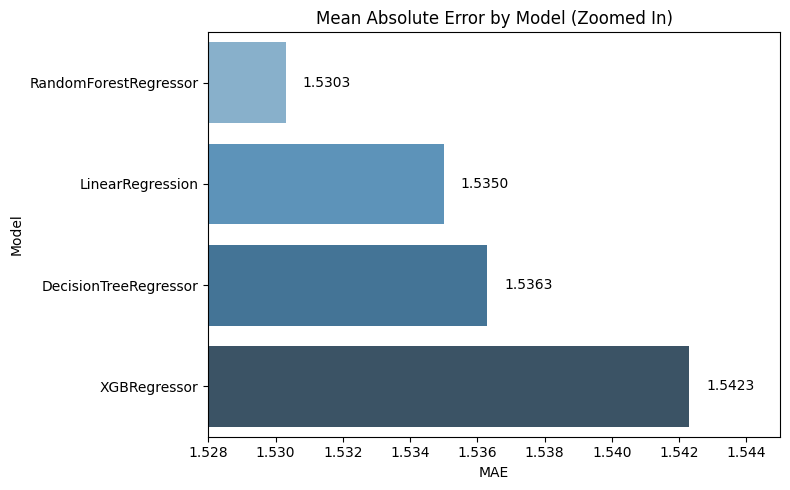

In [920]:
# Visualise results in a bar chart
# MAE values
mae_data = {
    "LinearRegression": 1.5350,
    "DecisionTreeRegressor": 1.5363,
    "RandomForestRegressor": 1.5303,
    "XGBRegressor": 1.5423
}

# Create and sort DataFrame
mae_df = pd.DataFrame(mae_data.items(), columns=["Model", "MAE"]).sort_values("MAE", ascending=True)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=mae_df,
    x="MAE",
    y="Model",
    palette="Blues_d",
    order=mae_df["Model"]
)

# Add text labels
for i, val in enumerate(mae_df["MAE"]):
    ax.text(val + 0.0005, i, f"{val:.4f}", va='center')

# Zoom in to emphasize differences
plt.xlim(1.528, 1.545)  # adjust as needed for your data
plt.title("Mean Absolute Error by Model (Zoomed In)")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

## Feature Importances

Lastly, I evaluated which features had the highest impacts on the created models.

In [921]:
# Feature importance for Linear Regression model
importance = pd.Series(model_lr.coef_, index=X_train_encoded.columns)
importance = importance.abs().sort_values(ascending=False)
print(importance)

MainBranch_simplified_Other                                                                                    1.168941
Country_means                                                                                                  0.829603
MainBranch_simplified_I am not primarily a developer, but I write code sometimes as part of my work/studies    0.301785
RemoteWork_In-person                                                                                           0.185388
Age_simplified                                                                                                 0.089786
EdLevel_simplified                                                                                             0.032915
RemoteWork_Remote                                                                                              0.032666
MainBranch_simplified_I used to be a developer by profession, but no longer am                                 0.029429
ConvertedCompYearly                     

<Axes: >

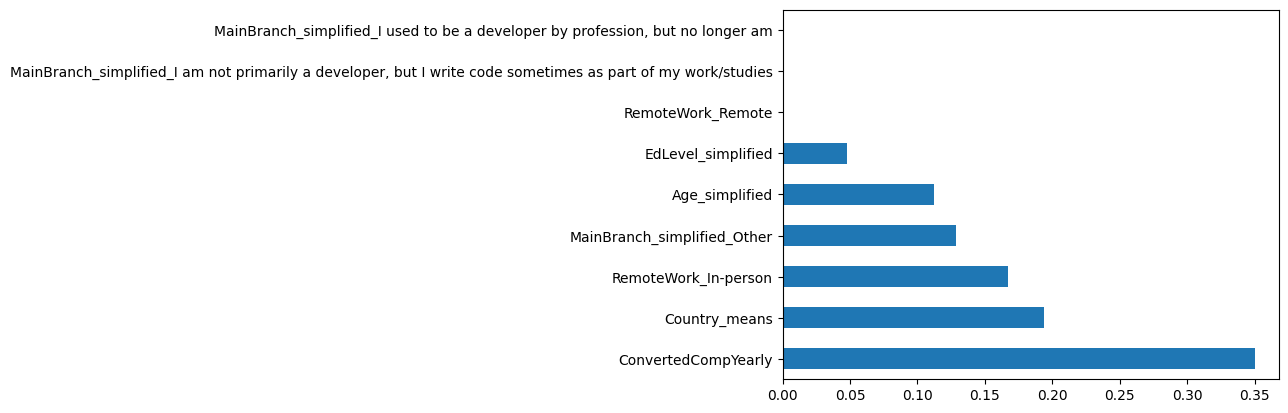

In [922]:
# Feature importance for Decision Tree model
importances = model_dtr.feature_importances_

# Display
feature_importance = pd.Series(importances, index=X_train_encoded.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh')

<Axes: >

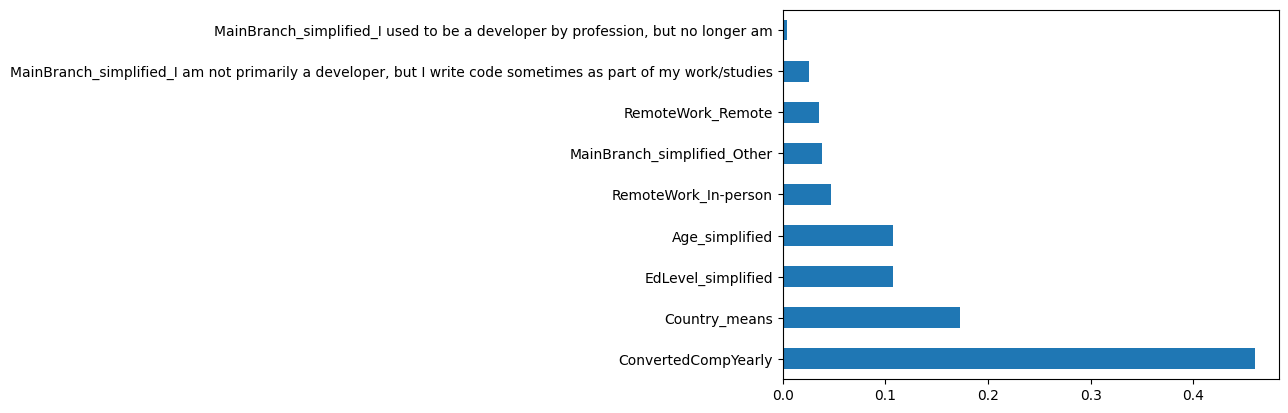

In [923]:
# Feature importance for Random Forest model
importances = model_rfr.feature_importances_

# Display
feature_importance = pd.Series(importances, index=X_train_encoded.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh')

## Evaluation

The performance of all models is similar, with the Random Forest Regressor performing best, however, only by 0.01 than the worst performing model.
Overall, the MAE of 1.53 is lower than the standard deviation of the Job Satisfaction Score and therefore an acceptable, however, not superb result.
The feature which had the highest impact on the Random Forest Regression model was Converted Compensation Yearly.